In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir("drive/My Drive/") # Change this to your current working directory

In [ ]:
model_ckpt = "MCG-NJU/videomae-large" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation

In [ ]:
!pip install transformers evaluate -q
!pip install -q git+https://github.com/facebookresearch/pytorchvideo
!pip install -U "huggingface_hub[cli]"
!huggingface-cli login --token <huggingface_token_here>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Pr

In [ ]:
!git config --global credential.helper store

### Loading the dataset


In [ ]:
from huggingface_hub import hf_hub_download

In [ ]:
import pathlib

dataset_root_path = pathlib.Path("./DSA4266 Project")

In [ ]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("validation/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 5500


In [ ]:
all_video_file_paths = [
    path for path in (
        list(dataset_root_path.glob("train/*/*.mp4"))
        + list(dataset_root_path.glob("validation/*/*.mp4"))
        + list(dataset_root_path.glob("test/*/*.mp4"))
    ) if not path.name.startswith("._") # .DS_Store
]

all_video_file_paths[:5]

[PosixPath('DSA4266 Project/train/deepfake/lbooddsyfl.mp4'),
 PosixPath('DSA4266 Project/train/deepfake/lbpfomllae.mp4'),
 PosixPath('DSA4266 Project/train/deepfake/lcmjyjdbqn.mp4'),
 PosixPath('DSA4266 Project/train/deepfake/lclyxqctwg.mp4'),
 PosixPath('DSA4266 Project/train/deepfake/lcegpefqvk.mp4')]

In [ ]:
class_labels = sorted({str(path).split("/")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['deepfake', 'real'].


In [ ]:
sample_rate = 4
fps = 30

### Loading the model

In [ ]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

In [ ]:
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
    num_frames=32
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Constructing the datasets for training

In [ ]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [ ]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
clip_duration = num_frames_to_sample * sample_rate / fps

# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=234, max_size=256),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "validation"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [ ]:
test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler(
        "constant_clips_per_video", clip_duration, 1
    ),
    decode_audio=False,
    transform=val_transform,
)

In [ ]:
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(3576, 824, 1100)

In [ ]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [ ]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")

investigate_video(sample_video)

video torch.Size([3, 40, 224, 224])
video_name jduilfrsta.mp4
video_index 630
clip_index 0
aug_index 0
label 0
Video label: deepfake


These functions are borrowed for visualisation purposes.


In [ ]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

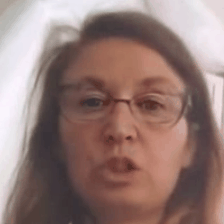

In [ ]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

### Training the model

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-deepfake-subset"
num_epochs = 15

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
    fp16=True
)

`collate_fn` is borrowed. This batches data together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [ ]:
import torch

def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    data_collator=collate_fn,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss
0,0.135600,0.460078
1,0.151800,0.415731


Exception ignored in: <function _xla_gc_callback at 0x788de5b9ee60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [ ]:
from huggingface_hub import create_repo
repo_id = "shylhy/videomae-large-finetuned-deepfake-subset"
create_repo(repo_id, private=False, exist_ok=True)

trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

## Inference

In [ ]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [ ]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
model_name = model_ckpt.split("/")[-1]
new_model_name = f"shylhy/{model_name}-finetuned-deepfake-subset"
model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/318k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

In [ ]:
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

In [ ]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
clip_duration = num_frames_to_sample * sample_rate / fps


# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler(
        "constant_clips_per_video", clip_duration, 1
    ),
    decode_audio=False,
    transform=val_transform,
)

In [ ]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 32, 224, 224])
video_name rdpumvchul.mp4
video_index 910
clip_index 0
aug_index 0
label 1
Video label: real


In [ ]:
def predict(model, video):
    """Utility to run inference given a model and test video.
    Returns the probability of the video being a deepfake.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    array = logits.flatten().exp()

    return (array[1] / sum(array)).item() # basically softmax

In [ ]:
import torch
id2label[round(predict(model, sample_test_video["video"]))]

'real'

In [ ]:
print(id2label[sample_test_video['label']])

real


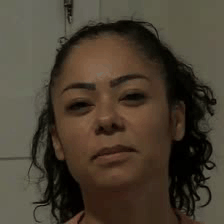

In [ ]:
display_gif(sample_test_video["video"])

In [ ]:
import pandas as pd


actual_labels = []
predicted_probabilities = []


for item in iter(test_dataset):
    actual_labels.append(item["label"])
    predicted_probabilities.append(predict(model, item["video"]))

# Create a Pandas DataFrame
df = pd.DataFrame({
    "actual_label": actual_labels,
    "predicted_probability": predicted_probabilities
})

In [ ]:
# Above, we had 0 = deepfake and 1 = real instead of 0 = real and 1 = deepfake like the other models
# This discrepancy was only realised after model training had begun
# To correct for this error, we correct the results.csv

corrected_df = 1 - df
corrected_df.to_csv('results-32-frames.csv', index=False)